In [100]:
import json
import essentia
import essentia.standard as es
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections 
from sklearn.neighbors import NearestNeighbors
import pickle
import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import classification_report
import random

In [2]:
with open('../data/pickles/main_dict.pickle', 'rb') as f:
    main_dict = pickle.load(f)

In [3]:
df = pd.read_csv('../data/csv/track_vectors_bow.csv', index_col=0)
df

,file,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ss_min,ss_std,sf_max,sf_mean,sf_min,sf_std,zcr_max,zcr_mean,zcr_min,zcr_std
0,108885_7,-828.793396,323.996399,-22.645792,-5.707085,35.534069,-14.166079,-4.683322,6.431343,-6.317684,...,2.137239,2.352414,0.164966,0.037403,0.012981,0.017506,0.036133,0.018456,0.002441,0.005484
1,095309_4,-637.838928,166.446960,-6.136036,46.390823,19.505096,18.494143,-9.090044,-2.106342,-2.007554,...,0.160476,0.614778,0.232799,0.097910,0.033257,0.040519,0.091797,0.027369,0.003418,0.012226
2,015541_5,-727.724121,172.740601,1.624757,42.806423,-4.108257,7.864232,-5.218000,4.374446,3.596553,...,0.282004,0.907480,0.226334,0.066599,0.015860,0.039021,0.060547,0.028188,0.003906,0.014537
3,046732_3,-717.759949,211.155151,17.932318,17.277416,17.350409,9.711357,17.276979,9.395988,9.956752,...,1.620362,0.840712,0.317309,0.121970,0.019016,0.060629,0.047852,0.015903,0.004395,0.009481
4,080518_6,-584.165833,114.918137,17.930492,40.438145,12.670935,-2.737741,0.588371,-3.887019,6.478685,...,0.906971,0.196970,0.349861,0.090468,0.032380,0.053152,0.146484,0.054396,0.009277,0.020462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63896,141561_4,-659.372375,117.638840,27.754400,34.788445,18.494167,-6.088364,-3.254398,-2.114888,-0.149268,...,0.365104,0.540709,0.402228,0.094400,0.022225,0.069277,0.234375,0.043659,0.000977,0.050088
63897,043844_2,-645.126587,122.071121,13.026981,20.820780,12.430963,3.860647,6.052197,7.274552,7.558539,...,1.043659,0.335486,0.522965,0.135151,0.017379,0.111030,0.279297,0.050843,0.000000,0.041153
63898,111871_3,-622.005859,179.936157,-25.739531,35.570972,-10.440171,24.467636,-16.438679,9.052222,-1.446382,...,1.330529,0.321333,0.233293,0.126991,0.078023,0.024530,0.051758,0.035078,0.006836,0.007523
63899,000212_8,-704.640320,158.871490,-3.703846,7.979444,-8.273800,-15.582794,-0.888886,3.670900,-10.424666,...,0.947472,0.618227,0.175798,0.045487,0.008317,0.036896,0.118652,0.048985,0.002930,0.020048


In [4]:
df_train = pd.read_csv('../data/csv/train.csv', index_col=0)
df_train

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
0,061010.mp3,-724.060181,174.672104,-22.694757,5.049683,-10.285789,-7.565227,-17.961994,-1.329323,-13.898221,...,0.737701,0.991601,0.240276,0.041676,8.983906e-03,0.031454,0.108398,0.029397,0.009277,0.014918
2,061589.mp3,-697.955811,112.710243,80.530632,18.408318,16.321367,33.912514,-1.067550,19.436161,2.497976,...,-0.194649,0.554220,0.488206,0.133584,1.799921e-02,0.079505,0.125000,0.028202,0.000977,0.020876
3,061493.mp3,-630.083130,135.834732,-17.474176,36.666378,20.877747,3.231712,0.163455,-4.143034,-7.589878,...,0.461225,0.344698,0.404520,0.101769,2.233087e-02,0.065322,0.267090,0.083095,0.006348,0.036801
4,061492.mp3,-692.294617,154.660141,-3.271099,31.385326,22.588284,4.178376,-0.790970,-4.321088,-4.325193,...,0.710971,0.538033,0.420857,0.083492,1.069842e-02,0.055768,0.450195,0.098991,0.005859,0.067057
5,061592.mp3,-708.504639,136.741913,9.762825,40.804737,17.343578,28.947464,15.307942,17.034895,9.786160,...,-0.039187,0.629073,0.458335,0.132431,6.568079e-11,0.090427,0.515137,0.018989,0.002441,0.039541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7977,131914.mp3,-654.926941,144.197983,-5.618096,12.815182,-4.743158,4.794647,-0.457318,2.406655,-8.439367,...,0.907090,0.585478,0.172700,0.063363,1.671647e-02,0.027547,0.136230,0.058892,0.012207,0.026086
7978,131772.mp3,-625.237183,158.683304,-10.997794,23.054964,11.636267,-1.839731,-17.972336,-9.967291,-12.986640,...,0.608825,0.747877,0.245719,0.111260,6.102545e-03,0.040364,0.070312,0.020365,0.005859,0.009048
7979,131792.mp3,-655.022644,144.006958,5.970843,14.379925,14.236056,3.561646,-4.041969,-4.800819,-3.666181,...,0.740162,0.707120,0.290256,0.078840,7.514172e-03,0.051776,0.104980,0.032318,0.000488,0.014633
7980,131624.mp3,-788.494507,75.723251,35.248608,28.392780,4.289547,18.946749,-5.460835,10.575089,-8.978883,...,0.130618,0.542250,0.212018,0.045943,9.695412e-04,0.043634,0.321289,0.102740,0.007812,0.053932


In [5]:
df_test = pd.read_csv('../data/csv/test.csv', index_col=0)
df_test

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_min,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std
7301,010673.mp3,-626.681091,132.151154,11.753740,45.711430,-0.209040,10.068515,-0.682384,5.395576,-4.435939,...,0.461337,0.281160,0.329500,0.124018,0.027167,0.045374,0.130859,0.031217,0.003418,0.019365
3931,066643.mp3,-687.945374,141.427277,-16.972485,19.092112,6.906140,3.117708,6.967309,-2.045398,-7.208217,...,-0.111801,0.627290,0.380662,0.080697,0.000165,0.061523,0.282227,0.049509,0.002930,0.025951
5176,000194.mp3,-782.241943,178.044266,-29.330959,18.219608,-14.123279,-10.458302,-16.387886,-5.279102,-16.686710,...,0.276664,0.634153,0.264619,0.043619,0.000129,0.038136,0.169922,0.037896,0.001953,0.017058
80,074421.mp3,-623.853394,122.672737,17.257471,4.505549,0.719744,-2.922961,-5.741470,-1.727011,-18.558123,...,0.421106,0.539590,0.264868,0.082399,0.007031,0.040712,0.224121,0.051835,0.009277,0.032241
7903,131553.mp3,-645.512512,74.718880,12.483846,45.145756,38.911320,16.187067,6.199753,0.013115,-3.431449,...,0.100123,0.391042,0.335317,0.112432,0.000625,0.050604,0.271973,0.079668,0.008789,0.049538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,075436.mp3,-800.051819,241.068558,40.636051,-0.057632,6.397528,-18.648108,-1.818632,3.204657,-0.186070,...,0.923011,1.546881,1.210505,0.112725,0.010022,0.145565,0.138184,0.015291,0.000488,0.012997
4878,063655.mp3,-758.179688,233.961899,28.287888,11.515189,6.204473,16.416714,-10.615239,0.827990,5.827968,...,1.715050,0.839399,1.088153,0.082296,0.024415,0.079127,0.032227,0.012229,0.000488,0.004685
5520,053301.mp3,-650.022522,133.733185,7.322467,12.278226,36.223629,19.627594,21.320019,11.456765,6.618299,...,0.419925,0.407566,0.518842,0.109679,0.016570,0.091477,0.231445,0.044514,0.002930,0.038336
3641,062526.mp3,-666.008362,121.186523,6.822075,42.061932,-10.464552,14.471254,7.220425,5.017753,-1.855397,...,0.230255,0.614144,0.625459,0.092227,0.006027,0.086389,0.187500,0.035097,0.001953,0.022623


In [6]:
df['new'] = [x[:-2] for x in df.file.values]
df

,file,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ss_std,sf_max,sf_mean,sf_min,sf_std,zcr_max,zcr_mean,zcr_min,zcr_std,new
0,108885_7,-828.793396,323.996399,-22.645792,-5.707085,35.534069,-14.166079,-4.683322,6.431343,-6.317684,...,2.352414,0.164966,0.037403,0.012981,0.017506,0.036133,0.018456,0.002441,0.005484,108885
1,095309_4,-637.838928,166.446960,-6.136036,46.390823,19.505096,18.494143,-9.090044,-2.106342,-2.007554,...,0.614778,0.232799,0.097910,0.033257,0.040519,0.091797,0.027369,0.003418,0.012226,095309
2,015541_5,-727.724121,172.740601,1.624757,42.806423,-4.108257,7.864232,-5.218000,4.374446,3.596553,...,0.907480,0.226334,0.066599,0.015860,0.039021,0.060547,0.028188,0.003906,0.014537,015541
3,046732_3,-717.759949,211.155151,17.932318,17.277416,17.350409,9.711357,17.276979,9.395988,9.956752,...,0.840712,0.317309,0.121970,0.019016,0.060629,0.047852,0.015903,0.004395,0.009481,046732
4,080518_6,-584.165833,114.918137,17.930492,40.438145,12.670935,-2.737741,0.588371,-3.887019,6.478685,...,0.196970,0.349861,0.090468,0.032380,0.053152,0.146484,0.054396,0.009277,0.020462,080518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63896,141561_4,-659.372375,117.638840,27.754400,34.788445,18.494167,-6.088364,-3.254398,-2.114888,-0.149268,...,0.540709,0.402228,0.094400,0.022225,0.069277,0.234375,0.043659,0.000977,0.050088,141561
63897,043844_2,-645.126587,122.071121,13.026981,20.820780,12.430963,3.860647,6.052197,7.274552,7.558539,...,0.335486,0.522965,0.135151,0.017379,0.111030,0.279297,0.050843,0.000000,0.041153,043844
63898,111871_3,-622.005859,179.936157,-25.739531,35.570972,-10.440171,24.467636,-16.438679,9.052222,-1.446382,...,0.321333,0.233293,0.126991,0.078023,0.024530,0.051758,0.035078,0.006836,0.007523,111871
63899,000212_8,-704.640320,158.871490,-3.703846,7.979444,-8.273800,-15.582794,-0.888886,3.670900,-10.424666,...,0.618227,0.175798,0.045487,0.008317,0.036896,0.118652,0.048985,0.002930,0.020048,000212


In [7]:
df_test['new'] = [x[:-4] for x in df_test.track.values]
df_test

,track,1_mfcc_1,1_mfcc_2,1_mfcc_3,1_mfcc_4,1_mfcc_5,1_mfcc_6,1_mfcc_7,1_mfcc_8,1_mfcc_9,...,all_ss_std,all_sf_max,all_sf_mean,all_sf_min,all_sf_std,all_zcr_max,all_zcr_mean,all_zcr_min,all_zcr_std,new
7301,010673.mp3,-626.681091,132.151154,11.753740,45.711430,-0.209040,10.068515,-0.682384,5.395576,-4.435939,...,0.281160,0.329500,0.124018,0.027167,0.045374,0.130859,0.031217,0.003418,0.019365,010673
3931,066643.mp3,-687.945374,141.427277,-16.972485,19.092112,6.906140,3.117708,6.967309,-2.045398,-7.208217,...,0.627290,0.380662,0.080697,0.000165,0.061523,0.282227,0.049509,0.002930,0.025951,066643
5176,000194.mp3,-782.241943,178.044266,-29.330959,18.219608,-14.123279,-10.458302,-16.387886,-5.279102,-16.686710,...,0.634153,0.264619,0.043619,0.000129,0.038136,0.169922,0.037896,0.001953,0.017058,000194
80,074421.mp3,-623.853394,122.672737,17.257471,4.505549,0.719744,-2.922961,-5.741470,-1.727011,-18.558123,...,0.539590,0.264868,0.082399,0.007031,0.040712,0.224121,0.051835,0.009277,0.032241,074421
7903,131553.mp3,-645.512512,74.718880,12.483846,45.145756,38.911320,16.187067,6.199753,0.013115,-3.431449,...,0.391042,0.335317,0.112432,0.000625,0.050604,0.271973,0.079668,0.008789,0.049538,131553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3341,075436.mp3,-800.051819,241.068558,40.636051,-0.057632,6.397528,-18.648108,-1.818632,3.204657,-0.186070,...,1.546881,1.210505,0.112725,0.010022,0.145565,0.138184,0.015291,0.000488,0.012997,075436
4878,063655.mp3,-758.179688,233.961899,28.287888,11.515189,6.204473,16.416714,-10.615239,0.827990,5.827968,...,0.839399,1.088153,0.082296,0.024415,0.079127,0.032227,0.012229,0.000488,0.004685,063655
5520,053301.mp3,-650.022522,133.733185,7.322467,12.278226,36.223629,19.627594,21.320019,11.456765,6.618299,...,0.407566,0.518842,0.109679,0.016570,0.091477,0.231445,0.044514,0.002930,0.038336,053301
3641,062526.mp3,-666.008362,121.186523,6.822075,42.061932,-10.464552,14.471254,7.220425,5.017753,-1.855397,...,0.614144,0.625459,0.092227,0.006027,0.086389,0.187500,0.035097,0.001953,0.022623,062526


In [8]:
df_bow_test = df[df['new'].isin(df_test['new'])]

In [9]:
df_bow_test.drop(columns=['new'], inplace=True)
df_bow_test

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,file,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ss_min,ss_std,sf_max,sf_mean,sf_min,sf_std,zcr_max,zcr_mean,zcr_min,zcr_std
35,062533_6,-671.198120,138.639709,22.230555,27.525738,-11.621864,1.630476,-2.902935,8.267635,-1.793859,...,0.576108,0.773675,0.465786,0.111594,0.021111,0.078257,0.233398,0.046089,0.006348,0.034583
242,024901_5,-580.970642,135.949112,-1.761406,5.122108,0.197555,12.185050,7.752786,3.857244,3.814994,...,1.426790,0.189749,0.215957,0.129661,0.082562,0.024722,0.092773,0.067759,0.007324,0.011257
551,010673_6,-600.906555,145.373917,11.210205,41.238419,1.708439,13.828434,-3.756881,2.842203,1.823862,...,0.395704,0.381958,0.324686,0.137615,0.059571,0.046039,0.094727,0.029022,0.003906,0.018538
776,044799_6,-658.365112,81.723038,5.717978,40.544865,25.803167,10.782271,9.888111,20.238461,10.660755,...,0.863627,0.404777,0.234706,0.096612,0.021225,0.047527,0.170410,0.054738,0.003418,0.035226
802,001040_6,-609.069214,87.350426,-6.621530,41.620632,-1.524995,25.443741,1.757494,-0.172147,-5.259410,...,0.270454,0.251764,0.366980,0.136764,0.035244,0.077057,0.158691,0.083883,0.012695,0.028897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63713,033020_2,-600.168884,149.759384,-32.586529,26.033113,-20.352365,-1.755566,-6.348417,-6.095432,-12.657984,...,0.722501,0.299043,0.164051,0.085534,0.039059,0.025556,0.105957,0.047714,0.003906,0.015856
63714,085027_1,-809.702759,259.068512,24.602499,14.581144,16.824120,12.827282,-15.624825,-3.438228,8.843854,...,2.010123,1.506663,0.179406,0.056331,0.018518,0.029045,0.054688,0.014261,0.002441,0.008144
63782,004233_3,-794.266541,177.278717,17.014393,55.412407,0.514055,-1.309268,-13.654597,-18.980249,-3.876530,...,-0.089377,1.386056,0.274898,0.073039,0.003515,0.050803,0.169922,0.026766,0.002441,0.030573
63854,075752_5,-659.443115,141.896500,24.623154,33.494846,16.867090,-5.384980,5.480534,7.794600,5.321544,...,0.168548,0.600200,0.328771,0.098454,0.025597,0.059866,0.259277,0.039781,0.004395,0.034828


In [10]:
df_bow_train = df.drop(df_bow_test.index)
df_bow_train.drop(columns=['new'], inplace=True)

In [11]:
X_train = df_bow_train.drop(columns=['file']).values
X_test = df_bow_test.drop(columns=['file']).values

In [12]:
scaler = StandardScaler()

In [13]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
X_train = scaler.transform(X_train)


In [15]:
X_test = scaler.transform(X_test)

In [16]:
n_clusters = 80

In [117]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, n_init=10)

In [118]:
kmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=80, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [119]:
clusters = kmeans.predict(X_train)

In [120]:
kmeans.n_iter_

174

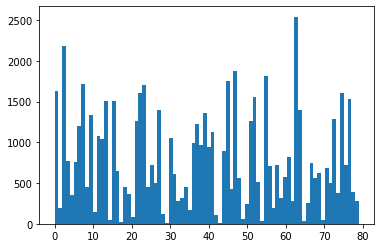

In [121]:
plt.hist(clusters, bins=n_clusters)
plt.show()

In [122]:
unique, counts = np.unique(clusters, return_counts=True)

In [123]:
a = np.asarray((unique, counts)).T
sorted(a, key=lambda x: x[1])

[array([29,  9]),
 array([43, 15]),
 array([17, 21]),
 array([54, 33]),
 array([65, 37]),
 array([14, 48]),
 array([70, 51]),
 array([49, 59]),
 array([20, 81]),
 array([ 42, 105]),
 array([ 28, 123]),
 array([ 10, 149]),
 array([ 35, 171]),
 array([  1, 188]),
 array([ 57, 190]),
 array([ 50, 241]),
 array([ 66, 258]),
 array([ 79, 275]),
 array([ 32, 279]),
 array([ 62, 284]),
 array([ 33, 312]),
 array([ 59, 316]),
 array([  4, 352]),
 array([ 19, 361]),
 array([ 74, 377]),
 array([ 78, 385]),
 array([ 46, 423]),
 array([ 24, 446]),
 array([ 18, 447]),
 array([ 34, 450]),
 array([  8, 458]),
 array([ 26, 500]),
 array([ 72, 500]),
 array([ 53, 511]),
 array([ 48, 560]),
 array([ 68, 563]),
 array([ 60, 575]),
 array([ 31, 614]),
 array([ 69, 625]),
 array([ 16, 651]),
 array([ 71, 682]),
 array([ 56, 706]),
 array([ 25, 720]),
 array([ 76, 724]),
 array([ 58, 725]),
 array([ 67, 752]),
 array([  5, 758]),
 array([  3, 774]),
 array([ 61, 822]),
 array([ 44, 894]),
 array([ 40, 940])

In [124]:
clusters_test = kmeans.predict(X_test)

In [125]:
df_bow_train['cluster'] = clusters
df_bow_test['cluster'] = clusters_test

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
df_bow_train

,file,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ss_std,sf_max,sf_mean,sf_min,sf_std,zcr_max,zcr_mean,zcr_min,zcr_std,cluster
0,108885_7,-828.793396,323.996399,-22.645792,-5.707085,35.534069,-14.166079,-4.683322,6.431343,-6.317684,...,2.352414,0.164966,0.037403,0.012981,0.017506,0.036133,0.018456,0.002441,0.005484,72
1,095309_4,-637.838928,166.446960,-6.136036,46.390823,19.505096,18.494143,-9.090044,-2.106342,-2.007554,...,0.614778,0.232799,0.097910,0.033257,0.040519,0.091797,0.027369,0.003418,0.012226,63
2,015541_5,-727.724121,172.740601,1.624757,42.806423,-4.108257,7.864232,-5.218000,4.374446,3.596553,...,0.907480,0.226334,0.066599,0.015860,0.039021,0.060547,0.028188,0.003906,0.014537,75
3,046732_3,-717.759949,211.155151,17.932318,17.277416,17.350409,9.711357,17.276979,9.395988,9.956752,...,0.840712,0.317309,0.121970,0.019016,0.060629,0.047852,0.015903,0.004395,0.009481,51
4,080518_6,-584.165833,114.918137,17.930492,40.438145,12.670935,-2.737741,0.588371,-3.887019,6.478685,...,0.196970,0.349861,0.090468,0.032380,0.053152,0.146484,0.054396,0.009277,0.020462,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63896,141561_4,-659.372375,117.638840,27.754400,34.788445,18.494167,-6.088364,-3.254398,-2.114888,-0.149268,...,0.540709,0.402228,0.094400,0.022225,0.069277,0.234375,0.043659,0.000977,0.050088,39
63897,043844_2,-645.126587,122.071121,13.026981,20.820780,12.430963,3.860647,6.052197,7.274552,7.558539,...,0.335486,0.522965,0.135151,0.017379,0.111030,0.279297,0.050843,0.000000,0.041153,44
63898,111871_3,-622.005859,179.936157,-25.739531,35.570972,-10.440171,24.467636,-16.438679,9.052222,-1.446382,...,0.321333,0.233293,0.126991,0.078023,0.024530,0.051758,0.035078,0.006836,0.007523,52
63899,000212_8,-704.640320,158.871490,-3.703846,7.979444,-8.273800,-15.582794,-0.888886,3.670900,-10.424666,...,0.618227,0.175798,0.045487,0.008317,0.036896,0.118652,0.048985,0.002930,0.020048,64


In [127]:
train_mtx = np.zeros((df_train.shape[0], n_clusters))
test_mtx = np.zeros((df_test.shape[0], n_clusters))

In [128]:
for i in range(df_train.shape[0]):
    track = df_train.iloc[i].track
    for j in range(1, 9):
        row = df_bow_train[df_bow_train.file == f'{track[:-4]}_{j}']
        cluster = row.cluster.values
        train_mtx[i][cluster] += 1

In [129]:
for i in range(df_test.shape[0]):
    track = df_test.iloc[i].track
    for j in range(1, 9):
        row = df_bow_test[df_bow_test.file == f'{track[:-4]}_{j}']
        cluster = row.cluster.values
        test_mtx[i][cluster] += 1

In [130]:
train_mtx /= 8
test_mtx /= 8

In [131]:
test_mtx[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [132]:
neigh = NearestNeighbors(10, metric='manhattan')
neigh.fit(train_mtx)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [133]:
def count_good_recommend(query_idx, answer_list, trhold):
    counter = 0
    query_id = int(df_test.iloc[query_idx].track[:-4])
    relevant = [query_id]
    query_tags = main_dict[query_id]['all_tags']
    for idx in answer_list:
        answer_id = int(df_train.iloc[idx].track[:-4])
        answer_tags = main_dict[answer_id]['all_tags']
        score = 0
        i = 0
        for tag in answer_tags:
            if tag in query_tags:
                i += 1
        if i == 0:
            continue
        
        precision = i / len(answer_tags)
        recall = i / len(query_tags)
        score = 2 * precision * recall / (precision + recall)
        if score >= trhold:        
            counter += 1
            relevant.append(answer_id)
    return counter, relevant

In [134]:
def count_ndcg(neighbors, relevant_list):
    dcg = 0
    idcg = 0
    for i in range(len(neighbors)):
        track = int(df_train.iloc[neighbors[i]].track[:-4])
        if track in relevant_list:
            dcg += 1 / math.log(i + 2, 2)
        idcg += 1 / math.log(i + 2, 2)
    ndcg = dcg / idcg
    return ndcg

In [135]:
mean_ap = 0
ndcg = 0
for i in range(100):
    neighbors = neigh.kneighbors([test_mtx[i]])[1][0]
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.3)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

In [136]:
mean_ap

0.09499999999999999

In [137]:
mean_ndcg

0.09566978006968561

In [138]:
cos_similarity_mtx = cosine_similarity(test_mtx, train_mtx)

In [139]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-10:][::-1]
    relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.3)
#     print(relevant_list)
#     print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in neighbors])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

In [140]:
mean_ap

0.09699999999999998

In [141]:
mean_ndcg

0.09728439725634978

In [142]:
with open('../data/tags_similarity.txt', 'r') as f:
    data = f.readlines()
all_similarity = [x.strip('\n').split() for x in data]

In [143]:
all_similarity[0]

['081512.mp3', '081781.mp3', '0.79']

In [144]:
df_train_2 = df_train.reset_index(drop=True)

In [145]:
features = list()
target = list()
for tupple in all_similarity:
    try:
        idx_1 = df_train_2[df_train_2.track == tupple[0]].index[0]
    except:
        pass
    idx_2 = df_train_2[df_train_2.track == tupple[1]].index[0]
    arr_1 = train_mtx[idx_1]
    arr_2 = train_mtx[idx_2]
    combo = np.hstack((arr_1, arr_2))
    features.append(combo)
    target.append(float(tupple[2]))

In [146]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1, 
    random_state=123
)

In [147]:
models = {
    'GBR': {
        'model': GradientBoostingRegressor(),
        'params': {
            'loss':['ls', 'lad', 'huber', 'quantile'],
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': np.arange(80, 120),
            'subsample': np.arange(0.6, 1.01, 0.1),
#             'min_samples_split': np.arange(20, 70),
#             'min_samples_leaf': np.arange(0.1, .51, 0.1),
            'max_features': np.arange(0.1, 1.01, 0.1),
            'max_depth': np.arange(3, 7)
            
        }
    },
    'LinReg': {
        'model': LinearRegression(),
        'params': {}
    },
    'LGBMR': {
        'model': LGBMRegressor(),
        'params': {
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': np.arange(80, 120),
            'subsample': np.arange(0.6, 1.01, 0.1),
            'min_split_gain': np.arange(0.1, 1.01, 0.1),
            'reg_lambda': np.arange(0.1, 1.01, 0.1)
            
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
            'C': np.arange(0.1, 1.01, 0.1),
            'epsilon': np.arange(0.1, 1.01, 0.1),
            'shrinking': np.arange(0.1, 1.01, 0.1),
            'max_iter': [1000]
        }
    }
}

In [148]:
for model_name in models.keys():
    model = models[model_name]['model']
    params = models[model_name]['params']
    r_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=100,
        scoring='r2',
        n_jobs = -1,
        random_state=123,
        error_score='raise' 
    )
    r_search.fit(features_train, target_train)
    y_pred_train = r_search.predict(features_train)
    y_pred_test = r_search.predict(features_test)
    rmse_train = mean_squared_error(target_train, y_pred_train)
    rmse_test = mean_squared_error(target_test, y_pred_test)
    r2_train = r2_score(target_train, y_pred_train)
    r2_test = r2_score(target_test, y_pred_test)
    print(model)
    print(r_search.best_params_)
#     print(classification_report(target_train, y_pred_train))
#     print(classification_report(target_test, y_pred_test))
    print(f'rmse {rmse_train}/{rmse_test} r2 {r2_train}/{r2_test}')

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
{'subsample': 0.7999999999999999, 'n_estimators': 119, 'max_features': 1.0, 'max_depth': 6, 'loss': 'huber', 'learning_rate': 0.1}
rmse 0.036779193821514705/0.05106053990725758 r2 0.38843074508501707/0.16606322019042796


/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
{}
rmse 0.05413071687381704/0.05674150112908044 r2 0.0999073457893751/0.07327997668859754
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
{'subsample': 0.7999999999999999, 'reg_lambda': 0.8, 'n_estimators': 86, 'min_split_gain': 0.1, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}
rmse 0.048064188759499415/0.05250939015036462 r2 0.20078237031543567/0.14240014282466618


/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
{'shrinking': 0.4, 'max_iter': 1000, 'kernel': 'rbf', 'epsilon': 0.1, 'C': 0.4}
rmse 0.034797329082318126/0.05195595129855618 r2 0.4213854516991603/0.15143908003012718


In [149]:
model = GradientBoostingRegressor(
    subsample=0.8, n_estimators=119, max_features=1, max_depth=6, loss='huber', learning_rate=0.1 
)

In [150]:
model.fit(features_train, target_train)
target_pred = model.predict(features_test)
target_train_pred = model.predict(features_train)

In [151]:
neigh = NearestNeighbors(100, metric='manhattan')
neigh.fit(train_mtx)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [152]:
def rank_by_model(model, neighb, arr_test):
    result = list()
    for idx in neighb:
        arr_2 = train_mtx[idx]
        combo = np.hstack((arr_test, arr_2))
        score = model.predict([combo])
#         score = model.predict_proba([combo])[:,1]
        result.append((idx, score))
    top_10 = sorted(result, key=lambda x: x[1], reverse=True)[:10]
    top_10 = [x[0] for x in top_10]

    return top_10

In [153]:
mean_ap = 0
ndcg = 0
for i in range(100):
    neighbors = neigh.kneighbors([test_mtx[i]])[1][0]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(level_2, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['110983', '069209', '085816', '076121', '038904', '080402', '126506', '063117', '012737', '047195']
66643 ['004094', '058221', '045475', '004098', '004072', '080517', '013328', '146150', '058215', '126426']
194 ['091937', '078213', '090529', '083911', '010682', '072612', '091793', '060857', '044778', '014579']
74421 ['081491', '149626', '125183', '052120', '085488', '114401', '103520', '126429', '146988', '130368']
131553 ['144467', '061668', '071507', '054155', '112020', '114201', '080517', '105408', '052042', '119582']
24431 ['142666', '129040', '127660', '081555', '114538', '116099', '123974', '072074', '036643', '114236']
144469 ['064861', '126455', '067011', '121654', '040243', '126550', '134979', '035296', '117887', '003905']
87100 ['122649', '010439', '108018', '108026', '129042', '087107', '144476', '108025', '093917', '124176']
69204 ['069196', '091620', '058063', '123973', '098585', '064410', '101868', '065488', '056802', '149625']
27454 ['003762', '087188', '110651', 

19759 ['074371', '011673', '043767', '060874', '004098', '107248', '042247', '066646', '107249', '050446']
41568 ['125620', '020366', '096695', '130992', '049394', '115892', '126417', '072781', '122936', '001195']
24429 ['071516', '098238', '074908', '089992', '134455', '134446', '042761', '079990', '138211', '141878']
86788 ['083789', '088854', '113274', '085791', '043698', '013325', '114414', '136054', '055716', '037730']
152418 ['134388', '038817', '004232', '134631', '058135', '024700', '069947', '011673', '043600', '024702']
64630 ['097697', '110779', '069833', '123968', '060041', '142086', '026008', '123647', '108745', '097814']
85832 ['003762', '087188', '052634', '066689', '075442', '142418', '055231', '069793', '101868', '048861']
75317 ['152545', '130170', '108498', '130650', '142569', '064522', '137895', '143290', '130456', '043857']
21401 ['126674', '028478', '142574', '007488', '058115', '130084', '075692', '147295', '106877', '068407']
71620 ['030198', '136134', '113303',

In [154]:
mean_ap

0.08499999999999995

In [155]:
mean_ndcg

0.08784929093048315

In [156]:
cos_similarity_mtx = cosine_similarity(test_mtx, train_mtx)

In [157]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['069209', '047195', '076121', '110983', '125004', '080402', '012737', '038904', '063117', '085816']
66643 ['004094', '023862', '126426', '064864', '129926', '009513', '121415', '126584', '137990', '056651']
194 ['060857', '010682', '078213', '091793', '072612', '044778', '083911', '090529', '016744', '043588']
74421 ['081491', '125183', '132561', '052120', '043865', '114401', '126429', '103520', '146988', '001682']
131553 ['144467', '071507', '112020', '105408', '052042', '053862', '099096', '058215', '123438', '122805']
24431 ['142666', '081555', '129040', '127660', '114538', '116099', '115892', '123974', '072074', '114236']
144469 ['064861', '067011', '126455', '003912', '121654', '088874', '040243', '126550', '121256', '134979']
87100 ['081814', '012067', '108018', '108026', '129042', '131917', '087107', '144476', '124177', '108025']
69204 ['069196', '051158', '148075', '098585', '123973', '118500', '094468', '123937', '055242', '140925']
27454 ['087188', '003762', '066689', 

1686 ['124425', '099364', '134388', '038817', '138318', '004232', '059688', '073675', '060871', '060864']
73365 ['134446', '027802', '004521', '115698', '098077', '043621', '119592', '112483', '120319', '053723']
5264 ['149626', '047070', '130921', '097586', '114401', '103520', '126429', '001682', '141181', '000212']
19759 ['074371', '023862', '042247', '126584', '129926', '121415', '045474', '069787', '113276', '056651']
41568 ['125620', '020366', '096695', '049394', '115892', '072781', '140421', '148124', '122936', '114072']
24429 ['134455', '134446', '079990', '138211', '133443', '124411', '082932', '075442', '019423', '141877']
86788 ['088854', '013325', '037730', '050752', '112526', '114198', '083790', '126186', '108503', '087151']
152418 ['134388', '038817', '059688', '060871', '073675', '134631', '003895', '098339', '080772', '060865']
64630 ['064604', '023353', '110779', '123977', '123968', '142086', '026008', '097814', '085040', '113453']
85832 ['087188', '003762', '066689', '

In [158]:
mean_ap

0.08099999999999997

In [159]:
mean_ndcg

0.008042961022334174

In [162]:
with_similar = list()
for idx in main_dict:
    if len(main_dict[idx]['similar_list']) > 0:
        with_similar.append(idx)

In [163]:
features = list()
target = list()
for idx in with_similar:
    track_1 = "{:06d}".format(idx) + '.mp3'
    if track_1 in df_train_2.track.values:
        id_1 = df_train_2[df_train_2.track == track_1].index[0]
        arr_1 = train_mtx[id_1]
        for pair in main_dict[idx]['similar_list']:
            artist, title, _ = pair
            for idx_2 in main_dict:
                if main_dict[idx_2]['artist_name'] == artist and main_dict[idx_2]['track_title'] == title:
                    track_2 = "{:06d}".format(idx_2) + '.mp3'
                    if track_2 in df_train_2.track.values:
                        id_2 = df_train_2[df_train_2.track == track_2].index[0]
                        arr_2 = train_mtx[id_2]
                        combo = np.hstack((arr_1, arr_2))
                        features.append(combo)
                        target.append(1)
                        break

In [164]:
len(target)

1898

In [165]:
while len(features) < (1898 * 2):
    pair = random.sample(list(df_train_2.track.values), 2)
    id_1 = int(pair[0][:-4])
    id_2 = int(pair[1][:-4])
    if len(set(main_dict[id_1]['all_genres']) & set(main_dict[id_2]['all_genres'])) == 0:
        idx_1 = df_train_2[df_train_2.track == pair[0]].index[0]
        idx_2 = df_train_2[df_train_2.track == pair[1]].index[0]
        arr_1 = train_mtx[idx_1]
        arr_2 = train_mtx[idx_2]
        combo = np.hstack((arr_1, arr_2))
        features.append(combo)
        target.append(0) 

In [166]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1, 
    random_state=123
)

In [104]:
models = {
    'GBC': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': np.arange(80, 120),
            'subsample': np.arange(0.6, 1.01, 0.1),
            'max_features': np.arange(0.1, 1.01, 0.1),
            'max_depth': np.arange(3, 7)
            
        }
    },
    'Logreg': {
        'model': LogisticRegression(),
        'params': {
            'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'C': np.arange(0.1, 1.01, 0.1),
            'max_iter': [1000]
        }
    },
    'LGBMC': {
        'model': LGBMClassifier(),
        'params': {
            'boosting_type': ['gbdt', 'dart', 'goss'],
            'learning_rate': [0.001, 0.01, 0.1],
            'n_estimators': np.arange(80, 120),
            'subsample': np.arange(0.6, 1.01, 0.1),
            'min_split_gain': np.arange(0.1, 1.01, 0.1),
            'reg_lambda': np.arange(0.1, 1.01, 0.1)
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
            'C': np.arange(0.1, 1.01, 0.1),
            'shrinking': np.arange(0.1, 1.01, 0.1),
            'max_iter': [1000]
        }
    }
}

In [105]:
for model_name in models.keys():
    model = models[model_name]['model']
    params = models[model_name]['params']
    r_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=100,
        scoring='roc_auc',
        n_jobs = -1,
        random_state=123,
        error_score='raise' 
    )
    r_search.fit(features_train, target_train)
    y_pred_train = r_search.predict(features_train)
    y_pred_test = r_search.predict(features_test)
#     rmse_train = mean_squared_error(target_train, y_pred_train)
#     rmse_test = mean_squared_error(target_test, y_pred_test)
#     r2_train = r2_score(target_train, y_pred_train)
#     r2_test = r2_score(target_test, y_pred_test)
    print(model)
    print(r_search.best_params_)
    print(classification_report(target_train, y_pred_train))
    print(classification_report(target_test, y_pred_test))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'subsample': 0.7, 'n_estimators': 113, 'max_features': 0.9, 'max_depth': 6, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1701
           1       0.91      0.92      0.92      1715

    accuracy                           0

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'solver': 'lbfgs', 'max_iter': 1000, 'C': 0.4}
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      1701
           1       0.62      0.64      0.63      1715

    accuracy                           0.62      3416
   macro avg       0.62      0.62      0.62      3416
weighted avg       0.62      0.62      0.62      3416

              precision    recall  f1-score   support

           0       0.60      0.60      0.60       197
           1       0.57      0.56      0.56       183

    accuracy                           0.58       380
   macro avg       0.58      0.58      0.58       380
weighted avg       0.58    

/home/obi-1-konobe/projects/mag/dp/dp_project/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
{'shrinking': 0.7000000000000001, 'max_iter': 1000, 'kernel': 'rbf', 'C': 1.0}
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1701
           1       0.89      0.96      0.92      1715

    accuracy                           0.92      3416
   macro avg       0.92      0.92      0.92      3416
weighted avg       0.92      0.92      0.92      3416

              precision    recall  f1-score   support

           0       0.68      0.64      0.66       197
           1       0.64      0.67      0.65       183

    accuracy                           0.66       380
   macro avg       0.66      0.66      0.66       380
weighted avg       0.66      0.66      0.66       380



In [167]:
model = LGBMClassifier(subsample=0.8, n_estimators=86, min_split_gain=0.1, learning_rate=0.1, boosting_type='gbdt')

In [168]:
model.fit(features_train, target_train)
target_pred = model.predict(features_test)
target_train_pred = model.predict(features_train)

In [169]:
neigh = NearestNeighbors(100, metric='manhattan')
neigh.fit(train_mtx)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='manhattan',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [170]:
def rank_by_model(model, neighb, arr_test):
    result = list()
    for idx in neighb:
        arr_2 = train_mtx[idx]
        combo = np.hstack((arr_test, arr_2))
#         score = model.predict([combo])
        score = model.predict_proba([combo])[:,1]
        result.append((idx, score))
    top_10 = sorted(result, key=lambda x: x[1], reverse=True)[:10]
    top_10 = [x[0] for x in top_10]

    return top_10

In [171]:
mean_ap = 0
ndcg = 0
for i in range(100):
    neighbors = neigh.kneighbors([test_mtx[i]])[1][0]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(level_2, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['111378', '122261', '102195', '145020', '106956', '084486', '117057', '028477', '134951', '106456']
66643 ['004520', '051918', '146150', '035545', '037368', '103521', '033072', '071304', '009152', '117670']
194 ['036999', '073658', '111186', '018038', '129922', '043590', '039666', '000540', '072562', '000546']
74421 ['111387', '130921', '085490', '108341', '144550', '017500', '052036', '129396', '097586', '148131']
131553 ['120200', '009559', '063226', '113031', '120513', '144467', '120194', '019760', '098622', '042475']
24431 ['016155', '033477', '054158', '122534', '115471', '027667', '129879', '108421', '051114', '076375']
144469 ['040238', '075431', '063208', '082928', '107578', '118922', '134797', '126317', '120326', '090027']
87100 ['069761', '043022', '126320', '117991', '001702', '149714', '000853', '000213', '120774', '010439']
69204 ['033064', '116242', '038365', '149750', '147780', '052631', '070654', '044820', '011766', '134943']
27454 ['122959', '040123', '085836', 

5264 ['081082', '118195', '053229', '053725', '027164', '087194', '149623', '092125', '037368', '047071']
19759 ['004520', '103521', '129374', '121312', '051918', '146969', '150266', '056273', '047201', '062196']
41568 ['120105', '126217', '116468', '122932', '085485', '001278', '028266', '121739', '123974', '000546']
24429 ['141878', '091851', '127915', '001196', '004519', '120296', '108478', '069784', '121926', '134962']
86788 ['096402', '054624', '087151', '083790', '011933', '013325', '147412', '124477', '135373', '037730']
152418 ['004022', '073100', '093986', '011946', '133028', '012350', '045508', '014590', '020374', '069764']
64630 ['112485', '149951', '129882', '033071', '132963', '146879', '064364', '051261', '085839', '085594']
85832 ['014735', '040123', '128477', '085836', '044801', '086576', '140924', '097960', '111372', '111221']
75317 ['075376', '149951', '007489', '075419', '152545', '130170', '108498', '011206', '130650', '113270']
21401 ['117630', '120203', '027164', 

In [172]:
mean_ap

0.08199999999999996

In [173]:
mean_ndcg

0.08298035836480601

In [174]:
cos_similarity_mtx = cosine_similarity(test_mtx, train_mtx)

In [175]:
mean_ap = 0
ndcg = 0
for i in range(100):
    arr = cos_similarity_mtx[i]
    neighbors = arr.argsort()[-100:][::-1]
    level_2 = rank_by_model(model, neighbors, test_mtx[i])
    relevant_num, relevant_list = count_good_recommend(i, level_2, trhold=0.3)
#     relevant_num, relevant_list = count_good_recommend(i, neighbors, trhold=0.4)
#     print(relevant_list)
    print(relevant_list[0], [df_train.iloc[x].track[:-4] for x in level_2])
    p_at_10 = relevant_num / 10
    mean_ap += p_at_10
    ndcg += count_ndcg(neighbors, relevant_list[1:])
mean_ap /= 100 
mean_ndcg = ndcg / 100

10673 ['111378', '122261', '102195', '145020', '106956', '084486', '117057', '028477', '134951', '084152']
66643 ['004520', '051918', '138071', '033072', '071304', '023862', '004094', '047201', '075194', '038781']
194 ['036999', '073658', '111186', '018038', '129922', '043590', '039666', '000540', '072562', '000546']
74421 ['085490', '130921', '144550', '017500', '121257', '052036', '129396', '097586', '148131', '135342']
131553 ['009559', '063226', '120513', '144467', '120194', '098622', '042475', '093944', '113261', '122648']
24431 ['016155', '033477', '115474', '122534', '118062', '115471', '027667', '129879', '108421', '051114']
144469 ['040238', '121256', '126885', '063208', '126587', '075432', '026754', '069188', '003911', '133833']
87100 ['043022', '001702', '149714', '054061', '000213', '120774', '047073', '010458', '027981', '116454']
69204 ['038365', '052631', '096657', '070654', '011766', '055232', '075378', '108524', '145752', '145755']
27454 ['085836', '014735', '128477', 

73365 ['053675', '004521', '140584', '108837', '009491', '078849', '089817', '107534', '104625', '082231']
5264 ['053229', '027164', '087194', '092125', '047071', '142550', '110107', '067237', '148131', '004071']
19759 ['004520', '103521', '129374', '051918', '138071', '146969', '150266', '047201', '062196', '115391']
41568 ['120105', '081543', '085485', '028266', '121739', '148124', '113022', '054235', '055286', '096694']
24429 ['014737', '131941', '138211', '127180', '113810', '098235', '120308', '133942', '067760', '114545']
86788 ['096402', '054624', '087151', '083790', '011933', '013325', '135373', '124477', '147412', '037730']
152418 ['153452', '043585', '093986', '106951', '014590', '020374', '124481', '057892', '115700', '126221']
64630 ['146879', '064364', '051261', '085839', '085594', '052644', '022091', '144423', '040845', '060472']
85832 ['014735', '040123', '128477', '085836', '044801', '086576', '140924', '097960', '111372', '111221']
75317 ['075419', '007489', '149951', 

In [176]:
mean_ap

0.07999999999999999

In [177]:
mean_ndcg

0.007925704856328796

In [17]:
features['lowlevel.mfcc.mean']

array([-8.2916156e+02,  1.9317177e+02,  4.2347931e+01,  5.4060452e+01,
       -2.3631012e+01, -1.9399572e+01,  6.8418140e+00, -1.7468027e+01,
       -1.2536197e+01, -5.9524351e-01, -4.3472978e-01,  1.5609742e+00,
       -6.0589099e+00], dtype=float32)

In [21]:
with open('../data/essentia/000534.json', 'r') as f:
    data = json.load(f)
data

{'metadata': {'version': {'essentia': '2.1-beta6-dev',
   'essentia_git_sha': 'v2.1_beta5-184-g344028cb',
   'extractor': 'music 2.0'},
  'audio_properties': {'analysis': {'equal_loudness': 0,
    'length': 29.9765758514,
    'sample_rate': 44100,
    'start_time': 0,
    'downmix': 'mix'},
   'bit_rate': 128000,
   'length': 29.9765758514,
   'lossless': 0,
   'number_channels': 2,
   'replay_gain': -9.71918869019,
   'sample_rate': 44100,
   'codec': 'mp3',
   'md5_encoded': '336cc18d14d663745b81b90bdfef8768'},
  'tags': {'file_name': '000534.mp3',
   'album': ['One Mind'],
   'artist': ['Charles Manson'],
   'date': ['2005'],
   'encodedby': ['iTunes v7.6.1.9'],
   'encoding': ['Lavf57.63.100'],
   'genre': ['Folk'],
   'title': ['I Can See You'],
   'tracknumber': ['1']}},
 'lowlevel': {'average_loudness': 0.513585805893,
  'barkbands_crest': {'max': 25.9294929504,
   'mean': 13.0073032379,
   'min': 4.34986209869,
   'stdev': 4.90071344376},
  'barkbands_flatness_db': {'max': 0.46

In [23]:
list(range(1, 31))

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]